# 2017/19 SWaT Data Analysis
Due to the amount of memory consumed in keeping both the dataframes and numpy arrays in the same Notebook. The analysis and ML will be performed in this notebook. The data required can be loaded using numpy and pickle.

In [2]:
import os
import pandas as pd
import numpy as np
from datetime import datetime
from datetime import timezone
import pickle

## Load preprocessed data


In [3]:
data2017_arr = np.load('data2017_arr.npy')
data2019_arr = np.load('data2019_arr.npy')

In [4]:
"""
This code is taken straight from: https://stackoverflow.com/questions/19201290/how-to-save-a-dictionary-to-a-file/32216025
"""

def save_obj(obj, name ):
    with open('obj/'+ name + '.pkl', 'wb+') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

def load_obj(name ):
    with open('obj/' + name + '.pkl', 'rb') as f:
        return pickle.load(f)

In [5]:
#unique_vals contains mapping from string features to numbers
unique_vals = load_obj("unique_vals")
features = load_obj("features")

In [11]:
y_data2019 = data2019_arr[:, -1]
y_data2017 = data2017_arr[:, -1]

X_data2019 = data2019_arr[:, 2:]
X_data2019 = X_data2019[:, :-1]
X_data2017 = data2017_arr[:, 2:]
X_data2017 = X_data2017[:, :-1]

X_concat = np.concatenate((X_data2017, X_data2019), axis=0)
y_concat = np.concatenate((y_data2017, y_data2019), axis=0)
#remove time and classification
features_red = features[2:-1]
print("X Shape: " + str(X_concat.shape))
print("y shape: " + str(y_concat.shape))
print("features shape: " + str(len(features_red)))

X Shape: (6806361, 46)
y shape: (6806361,)
features shape: 46


## This performs the standard Classification
Currently only using Decision Tree. The amount of data means that classifiers like SVM just won't work. <br>
Need to decide how I want to split the data, currently cross_val_score completely messes the data around taking it out of context (but then regardless of whether it's taken out of context - a classifier will not be interpreting it in its context). 

In [16]:
#!/usr/bin/python
# -*- coding: utf-8 -*-

"""
=====================
Classifier comparison
=====================

A comparison of a several classifiers in scikit-learn on synthetic datasets.
The point of this example is to illustrate the nature of decision boundaries
of different classifiers.
This should be taken with a grain of salt, as the intuition conveyed by
these examples does not necessarily carry over to real datasets.

Particularly in high-dimensional spaces, data can more easily be separated
linearly and the simplicity of classifiers such as naive Bayes and linear SVMs
might lead to better generalization than is achieved by other classifiers.

The plots show training points in solid colors and testing points
semi-transparent. The lower right shows the classification accuracy on the test
set.
"""

# Code source: Gaël Varoquaux
#              Andreas Müller
# Modified for documentation by Jaques Grobler
# License: BSD 3 clause

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold

h = .02  # step size in the mesh

names = [#"Nearest Neighbors", "Linear SVM", "RBF SVM", "Gaussian Process",
         "Decision Tree", #"Random Forest", "Neural Net", "AdaBoost",
         #"Naive Bayes", "QDA"
        ]

classifiers = [
    #KNeighborsClassifier(3),
    #SVC(kernel="linear", C=0.025),
    #SVC(gamma=2, C=1),
    #GaussianProcessClassifier(1.0 * RBF(1.0)),
    DecisionTreeClassifier(),
    #RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    #MLPClassifier(alpha=1, max_iter=1000),
    #AdaBoostClassifier(),
    #GaussianNB(),
    #QuadraticDiscriminantAnalysis()
    ]


# iterate over classifiers
scores = []
for name, clf in zip(names, classifiers):
    
    rcv = RepeatedStratifiedKFold(n_splits=10, n_repeats=4)
    scores.extend(cross_val_score(clf, X_concat, y_concat, cv=rcv, scoring="roc_auc"))
    
    #clf.fit(X_data2019, y_data2019)
    #score = clf.score(X_data2017, y_data2017)
    
    print(name + ": " + str(np.mean(scores)) + " +- " + str(np.var(scores)))
    print(scores)



KeyboardInterrupt: 

## Simple Inbuilt Feature Importance
This just fits classifier(s) to all the data multiple times and notes down the feature importances for each feature (it doesn't preserve direction - absolute values are used). This allows us to see which features and most influential in a classifier's decision making process

In [ ]:
"""
Get inbuilt feature importance 100 times due to small variations in importance
"""
def use_inbuilt_feature_imp(claf, names, X, y):
    feature_imp_dict = {}
    for name, clf in zip(names, claf):
        for ip in range(0,100):
            clf.fit(X, y)
            sorted_importances = []
            index =0
            try:
                for i in clf.feature_importances_:
                    sorted_importances.append((index, i))
                    index+=1
            except AttributeError:
                for i in clf.coef_[0]:
                    sorted_importances.append((index, i))
                    index+=1
            sorted_importances.sort(key = lambda tup : tup[1], reverse=True)
            feature_imp_dict[name + str(ip)] = sorted_importances
    return feature_imp_dict

clf=[DecisionTreeClassifier()]
names = ["Decision Tree"]

feature_imp_dict = use_inbuilt_feature_imp(clf, names, X_concat, y_concat)

## Streaming Classifier
This is more experimental. It uses a streaming classifier which continues to learn as it is presented with more data (these are particularly useful for large quantities of data and real-life applications). Not sure I'll use it as it's not easy to obtain feature importances.

<IPython.core.display.Javascript object>


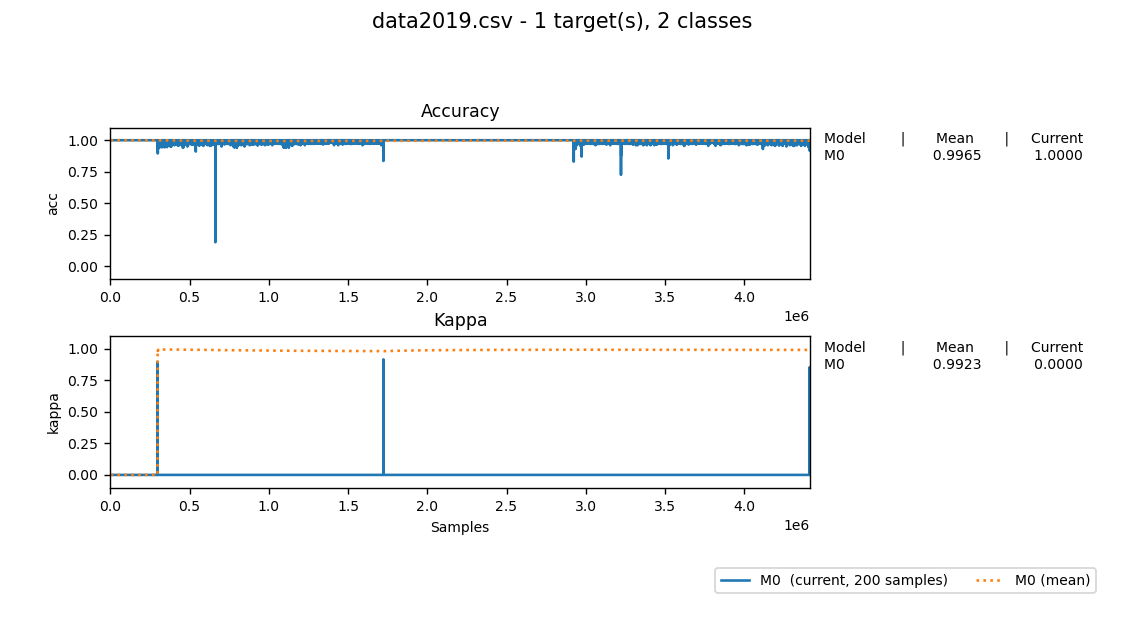

Prequential Evaluation
Evaluating 1 target(s).
Pre-training on 1000 sample(s).
Evaluating...
 #################### [100%] [2538.23s]
Processed samples: 4415014
Mean performance:
M0 - Accuracy     : 0.9965
M0 - Kappa        : 0.9923


In [12]:
%matplotlib notebook
from skmultiflow.data import FileStream
from skmultiflow.trees import HoeffdingTreeClassifier
from skmultiflow.evaluation import EvaluatePrequential

stream = FileStream("E:/Code/SWaT/data2019.csv")

# 2. Instantiate the HoeffdingTreeClassifier
ht = HoeffdingTreeClassifier()

evaluator = EvaluatePrequential(show_plot=True,
                                 pretrain_size=1000,
                                 max_samples=6000000)

ht_final_model = evaluator.evaluate(stream=stream, model=ht)